In [4]:
import numpy as np
import scipy.stats as st
import copy
import math
import matplotlib
from matplotlib import pyplot as plt

In [73]:
alph = 5

In [76]:
class Oracle:
    def __init__(self, p, pi):
        assert(p.shape[1] == pi.shape[0])
        self.__pi = copy.copy(pi)
        self.__p = copy.copy(p)
        self.__calc = 0
        self.__grad = 0
        self.__gess = 0
    
    def Calculate(self, x):
        self.__calc += 1
        return np.sum(self.__pi * np.log(self.__p.T @ x))
    
    def CalculateGradient(self, x):
        self.__grad += 1
        return self.__p @ (self.__pi * (self.__p.T @ x)**(-1))
    
    def CalculateGessian(self, x):
        self.__gess += 1
        return -1.0 * self.__p @ np.diagflat(self.__pi * (self.__p.T @ x)**(-2)) @ self.__p.T
    
    @property
    def Calculated(self):
        return self.__calc;
    
    @property
    def CalculatedGradients(self):
        return self.__grad;
    
    @property
    def CalculatedGessians(self):
        return self.__gess;
    
    
class BarierOracle:
    def __init__(self, p, pi, t):
        assert(p.shape[1] == pi.shape[0])
        self.__pi = copy.copy(pi)
        self.__p = copy.copy(p)
        self.__t = t
        self.__calc = 0
        self.__grad = 0
        self.__gess = 0
    
    def Calculate(self, x):
        self.__calc += 1
        return np.sum(self.__pi * np.log(self.__p.T @ x))
    
    def CalculateGradient(self, x):
        self.__grad += 1
        return self.__p @ (self.__pi * (self.__p.T @ x)**(-1)) + self.__t * np.array([1 / xi for xi in x])
    
    def CalculateGessian(self, x):
        self.__gess += 1
        return -1.0 * self.__p @ np.diagflat(self.__pi * (self.__p.T @ x)**(-2)) @ self.__p.T - \
    self.__t * np.diag([1 / xi**2 for xi in x]) 
    
    @property
    def Calculated(self):
        return self.__calc;
    
    @property
    def CalculatedGradients(self):
        return self.__grad;
    
    @property
    def CalculatedGessians(self):
        return self.__gess;
    
def Normalization(A):
    assert(A.shape[0] == A.shape[1])
    return A - np.eye(A.shape[0])
    
class NewtonIterator:
    def __init__(self, begin, oracle, projector, step_choser, priority, checker, normalizator):
        self.__point = copy.copy(begin)
        self.__oracle = copy.copy(oracle)
        self.__projector = copy.copy(projector)
        self.__step_choser = copy.copy(step_choser)
        self.__priority = copy.copy(priority)
        self.__checker = copy.copy(checker)
        self.__normalizator = copy.copy(normalizator)
        self.__step = 1.0
        self.__value = oracle.Calculate(begin)
    def MakeStep(self):
        gess = self.__oracle.CalculateGessian(self.__point)
        grad = self.__oracle.CalculateGradient(self.__point)
        gess = np.linalg.inv(self.__normalizator(gess))
        direction = gess @ self.__projector(grad)
        old_value = self.__value
        improve = False
        while (not improve):
            new_point = self.__point - self.__step * direction
            if (not self.__checker(new_point)):
                self.__step = self.__step_choser(self.__step, False)
            else:
                new_value = self.__oracle.Calculate(new_point)
                improve = self.__priority(new_value, old_value)
                self.__step = self.__step_choser(self.__step, improve)
                if (improve):
                    self.__point = new_point
                    self.__value = new_value
    
    @property
    def Oracle(self):
        return self.__oracle
    
    @property
    def Value(self):
        return self.__value
    
    @property
    def Point(self):
        return self.__point
    
def Projector(x):
    y = x - (np.ones(x.size) @ x) * np.ones(x.size) / x.size
    return y

def StepChoser(prev, success):
    next = prev
    if success:
        if (next < 1.0):
            next *= 2.0
            if (next > 1):
                next = 1.0
    else:
        next /= 2.0
    return next 

def Checker(x):
    if (not np.all(x > 0)):
        return False
    else:
        return True
                               
class BarierNewtonSpecializator(NewtonIterator):
    def __init__(self, begin, p, pi, t):
        priority = lambda x, y: x >= y
        NewtonIterator.__init__(self, begin, BarierOracle(p, pi, t), Projector, StepChoser, priority, Checker, Normalization) 

def FindMax(begin, p, pi, t, mistake):
    iterator = BarierNewtonSpecializator(begin, p, pi, t)
    prev = iterator.Value
    finished = False
    while(not finished):
        iterator.MakeStep()
        next = iterator.Value
        finished = (np.abs(next - prev) < mistake)
        prev = next
    return iterator
        
def InnerPoint(begin, p, pi, mistake):
    t = 1
    m = len(begin)
    iterator = BarierNewtonSpecializator(begin, p, pi, t)
    finished = False
    while(not finished):
        iterator = FindMax(iterator.Point, p, pi, t, m * t)
        finished = (m * t < mistake)
        t /= alph
    return point

def InnerPointsWithGraph(begin, p, pi, mistake, need_graph):
    real_oracle = Oracle(p, pi)
    t = 1
    m = len(begin)
    Calculated = 0
    CalculatedGradients = 0
    CalculatedGessians = 0
    iterator = BarierNewtonSpecializator(begin, p, pi, t)
    iterations = [real_oracle.Calculate(iterator.Point)]
    finished = False
    while(not finished):
        iterator = FindMax(iterator.Point, p, pi, t, m * t)
        Calculated += iterator.Oracle.Calculated
        CalculatedGradients += iterator.Oracle.CalculatedGradients
        CalculatedGessians += iterator.Oracle.CalculatedGessians
        iterations.append(real_oracle.Calculate(iterator.Point))
        finished = (m * t < mistake)
        t /= alph
    if (need_graph):
        plt.xlabel("Iteration")
        plt.ylabel("Difference with final value")
        plt.plot(np.arange(len(iterations)) + 1, iterations[-1] - iterations, "b-")
        plt.show()
    return (Calculated, CalculatedGradients, CalculatedGessians, iterator)

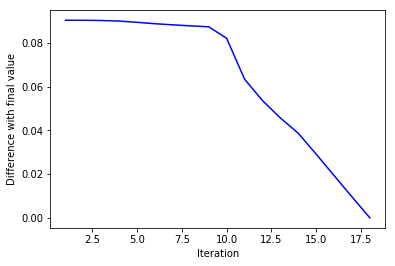

Calculated:
Function:  378
Gradient:  214
Gessian:  214
Point:  [1.30992363e-10 3.45431078e-10 3.33163120e-10 8.18933511e-10
 1.06174305e+00 1.81580441e-10 2.19796668e-10 3.90824582e-10
 2.82874200e-10 3.07298730e-10]
Value:  1.9623037681609854


In [77]:
n = 10
m = 100

p = np.abs(np.random.rand(n, m) * 3 + 5)
pi = np.abs(np.random.rand(m))
pi /= np.sum(pi)

begin = np.ones(n) / n

calc = InnerPointsWithGraph(begin, p, pi, 10**(-10), True)

print("Calculated:")
print("Function: ", calc[0])
print("Gradient: ", calc[1])
print("Gessian: ", calc[2])
print("Point: ", calc[3].Point)
print("Value: ", calc[3].Value)

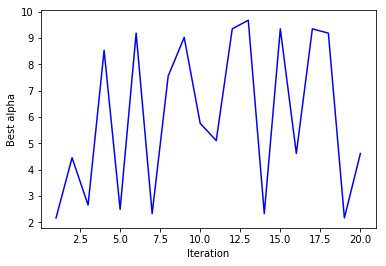

In [78]:
n = 10
m = 100

bests = []

for i in range(20):
    p = np.abs(np.random.rand(n, m) * 3 + 5)
    pi = np.abs(np.random.rand(m))
    pi /= np.sum(pi)

    begin = np.ones(n) / n

    best = 0
    gess = 10**10
    for alph in np.linspace(2, 10, 50):
        calc = InnerPointsWithGraph(begin, p, pi, 10**(-10), False)
        if (gess > calc[2]):
            gess = calc[2]
            best = alph
    bests.append(best)

plt.xlabel("Iteration")
plt.ylabel("Best alpha")
plt.plot(np.arange(20) + 1, bests, "b-")
plt.show()
